In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd /gdrive/My\ Drive/Shell\ Hackathon/

/gdrive/My Drive/Shell Hackathon


In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pickle
from datetime import datetime
from sklearn.svm import SVR
from   math   import radians as DegToRad       # Degrees to radians Conversion
from shapely.geometry import Point             # Imported for constraint checking
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore")



In [4]:
class LayoutGridMCGenerator:
  def __init__(self):
    return

  # rows : number of rows in wind farm
  # cols : number of columns in wind farm
  # n : number of layouts
  # N : number of turbines
  def gen_mc_grid(rows, cols, n, N, lofname):  # , xfname): generate monte carlo wind farm layout grids
    np.random.seed(seed=int(time.time()))  # init random seed
    layouts = np.zeros((n, rows * cols), dtype=np.int32)  # one row is a layout
    # layouts_cr = np.zeros((n*, 2), dtype=np.float32)  # layouts column row index
    positionX = np.random.randint(0, cols, size=(N * n * 2))
    positionY = np.random.randint(0, rows, size=(N * n * 2))
    ind_rows = 0  # index of layouts from 0 to n-1
    ind_pos = 0  # index of positionX, positionY from 0 to N*n*2-1
    # ind_crs = 0
    while ind_rows < n:
      layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
      if np.sum(layouts[ind_rows, :]) == N:
        # for ind in range(rows * cols):
        #     if layouts[ind_rows, ind] == 1:
        #         r_i = np.floor(ind / cols)
        #         c_i = np.floor(ind - r_i * cols)
        #         layouts_cr[ind_crs, 0] = c_i
        #         layouts_cr[ind_crs, 1] = r_i
        #         ind_crs += 1
        ind_rows += 1
      ind_pos += 1
      if ind_pos >= N * n * 2:
        print("Not enough positions")
        break
    # filename = "positions{}by{}by{}N{}.dat".format(rows, cols, n, N)
    np.savetxt(lofname, layouts, fmt='%d', delimiter=" ")
    # np.savetxt(xfname, layouts_cr, fmt='%d', delimiter=" ")
    # print()
    # print("generated grid layouts: "layouts.shape)
    # print(layouts)
    return layouts


  # rows : number of rows in wind farm
  # cols : number of columns in wind farm
  # n : number of layouts
  # N : number of turbines
  # generate population
  # returns layouts : (n, rows * cols) matrix with 1 for cell allocated and 0 for no turbine
  def gen_pop(rows, cols, n, N):  # generate population very similar to gen_mc_grid, just without saving layouts to a file
    np.random.seed(seed=int(time.time())) #init random seed
    layouts = np.zeros((n, rows * cols), dtype=np.int32) # one row is a layout, NA loc is 0
    positionX = np.random.randint(0, cols, size=(N * n * 2))
    positionY = np.random.randint(0, rows, size=(N * n * 2))
    ind_rows = 0  # index of layouts from 0 to n-1
    ind_pos = 0  # index of positionX, positionY from 0 to N*n*2-1
    N_count = 0

    while ind_rows < n:
      layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
      if np.sum(layouts[ind_rows, :]) == N:
        ind_rows += 1
      ind_pos += 1
      if ind_pos >= N * n * 2:
        print("Not enough positions")
        break
    return layouts


In [32]:
class simple_scan:
  def __init__(self, rows=21, cols=21, N=0, pop_size=100, iteration=200, cell_width=400, wind_data_file_name='wind_data_2007.csv', power_curve_file_name='power_curve.csv'):
    self.turb_specs = {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                     }
    self.turb_diam = self.turb_specs['Dia (m)']
    self.turb_rad = self.turb_diam/2
    self.rows = rows
    self.cols = cols
    self.N = N
    self.pop_size = pop_size
    self.iteration = iteration

    self.cell_width = cell_width
    self.cell_width_half = cell_width * 0.5

    self.init_pop = None
    self.init_pop_nonezero_indices = None

    self.wind_data_file_name = wind_data_file_name
    self.power_curve_file_name = power_curve_file_name

    self.power_curve = self.load_power_curve(power_curve_file_name=self.power_curve_file_name)
    self.wind_inst_freq = self.bin_wind_resource_data(wind_data_file_name = self.wind_data_file_name)
    self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t = self.pre_processing(self.power_curve)

    return
  
  def gen_init_pop(self):
    self.init_pop = LayoutGridMCGenerator.gen_pop(rows=self.rows, cols=self.cols, n=self.pop_size, N=self.N)
    self.init_pop_nonezero_indices = np.zeros((self.pop_size, self.N), dtype=np.int32)
    for ind_init_pop in range(self.pop_size):
      ind_indices = 0
      for ind in range(self.rows * self.cols):
        if self.init_pop[ind_init_pop, ind] == 1:
          self.init_pop_nonezero_indices[ind_init_pop, ind_indices] = ind
          ind_indices += 1
    
    # print()
    # print("generated intial population: ")
    # print("init_pop", self.init_pop)
    # print("init_pop_nonezero_indices", self.init_pop_nonezero_indices)
    return
  
  def save_init_pop(self, fname):
    np.savetxt(fname, self.init_pop, fmt="%d", delimiter=" ")
    return

  def load_init_pop(self, fname):
    self.init_pop = np.genfromtxt(fname, delimiter=" ", dtype=np.int32)
    self.init_pop_nonezero_indices = np.zeros((self.pop_size, self.N), dtype=np.int32)
    for ind_init_pop in range(self.pop_size):
      ind_indices = 0
      for ind in range(self.rows * self.cols):
        if self.init_pop[ind_init_pop, ind] == 1:
          self.init_pop_nonezero_indices[ind_init_pop, ind_indices] = ind
          ind_indices += 1
    return

  def search_sorted(self, lookup, sample_array):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Returns lookup indices for closest values w.r.t sample_array elements
    
    :called_from
        preProcessing, getAEP
    
    :param
        lookup       - The lookup array
        sample_array - Array, whose elements need to be matched
                       against lookup elements. 
        
    :return
        lookup indices for closest values w.r.t sample_array elements 
    """
    lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
    idx1 = np.searchsorted(lookup_middles, sample_array)
    indices = np.arange(lookup.shape[0])[idx1]
    return indices

  def load_power_curve(self, power_curve_file_name):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Returns a 2D numpy array with information about
    turbine thrust coeffecient and power curve of the 
    turbine for given wind speed
    
    :called_from
        main function
    
    :param
        power_curve_file_name - power curve csv file location
        
    :return
        Returns a 2D numpy array with cols Wind Speed (m/s), 
        Thrust Coeffecient (non dimensional), Power (MW)
    """
    powerCurve = pd.read_csv(power_curve_file_name, sep=',', dtype = np.float32)
    powerCurve = powerCurve.to_numpy(dtype = np.float32)
    return(powerCurve)

  def bin_wind_resource_data(self, wind_data_file_name):
    r"""
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Loads the wind data. Returns a 2D array with shape (36,15). 
    Each cell in  array is a wind direction and speed 'instance'. 
    Values in a cell correspond to probability of instance
    occurence.  
    
    :Called from
        main function
        
    :param
        wind_data_file_name - Wind Resource csv file  
        
    :return
        1-D flattened array of the 2-D array shown below. Values 
        inside cells, rough probabilities of wind instance occurence. 
        Along: Row-direction (drct), Column-Speed (s). Array flattened
        for vectorization purpose. 
        
                      |0<=s<2|2<=s<4| ...  |26<=s<28|28<=s<30|
        |_____________|______|______|______|________|________|
        | drct = 360  |  --  |  --  |  --  |   --   |   --   |
        | drct = 10   |  --  |  --  |  --  |   --   |   --   |
        | drct = 20   |  --  |  --  |  --  |   --   |   --   |
        |   ....      |  --  |  --  |  --  |   --   |   --   |
        | drct = 340  |  --  |  --  |  --  |   --   |   --   |
        | drct = 350  |  --  |  --  |  --  |   --   |   --   |        
    """
    
    # Load wind data. Then, extracts the 'drct', 'sped' columns
    df = pd.read_csv(wind_data_file_name)
    wind_resource = df[['drct', 'sped']].to_numpy(dtype = np.float32)
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1

    
    # placeholder for binned wind
    binned_wind = np.zeros((n_slices_drct, n_slices_sped), 
                           dtype = np.float32)
    
    # 'trap' data points inside the bins. 
    for i in range(n_slices_drct):
      for j in range(n_slices_sped):      
        # because we already have drct in the multiples of 10
        foo = wind_resource[(wind_resource[:,0] == slices_drct[i])] 

        foo = foo[(foo[:,1] >= slices_sped[j]) 
                      & (foo[:,1] <  slices_sped[j+1])]
        
        binned_wind[i,j] = foo.shape[0]  
  
    wind_inst_freq   = binned_wind/np.sum(binned_wind)
    wind_inst_freq   = wind_inst_freq.ravel()
    
    return(wind_inst_freq)

  def pre_processing(self, power_curve):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Doing preprocessing to avoid the same repeating calculations.
    Record the required data for calculations. Do that once.
    Data are set up (shaped) to assist vectorization. Used later in
    function totalAEP. 
    
    :called_from
        main function
    
    :param
        power_curve - 2D numpy array with cols Wind Speed (m/s), 
                      Thrust Coeffecient (non dimensional), Power (MW)
        
    :return
        n_wind_instances  - number of wind instances (int)
        cos_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        sin_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        wind_sped_stacked - column staked all speed instances n_turb times. 
        C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                            Value changing only along axis=0. C_t, thrust coeff.
                            values for all speed instances. 
    """
    # number of turbines
    n_turbs       =   50
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1
    
    # number of wind instances
    n_wind_instances = (n_slices_drct)*(n_slices_sped)
    
    # Create wind instances. There are two columns in the wind instance array
    # First Column - Wind Speed. Second Column - Wind Direction
    # Shape of wind_instances (n_wind_instances,2). 
    # Values [1.,360.],[3.,360.],[5.,360.]...[25.,350.],[27.,350.],29.,350.]
    wind_instances = np.zeros((n_wind_instances,2), dtype=np.float32)
    counter = 0
    for i in range(n_slices_drct):
      for j in range(n_slices_sped):
        wind_drct =  slices_drct[i]
        wind_sped = (slices_sped[j] + slices_sped[j+1])/2
        
        wind_instances[counter,0] = wind_sped
        wind_instances[counter,1] = wind_drct
        counter += 1

	    # So that the wind flow direction aligns with the +ve x-axis.			
    # Convert inflow wind direction from degrees to radians
    wind_drcts =  np.radians(wind_instances[:,1] - 90)
    # For coordinate transformation 
    cos_dir = np.cos(wind_drcts).reshape(n_wind_instances,1)
    sin_dir = np.sin(wind_drcts).reshape(n_wind_instances,1)
    
    # create copies of n_wind_instances wind speeds from wind_instances
    wind_sped_stacked = np.column_stack([wind_instances[:,0]]*n_turbs)
   
    # Pre-prepare matrix with stored thrust coeffecient C_t values for 
    # n_wind_instances shape (n_wind_instances, n_turbs, n_turbs). 
    # Value changing only along axis=0. C_t, thrust coeff. values for all 
    # speed instances.
    # we use power_curve data as look up to estimate the thrust coeff.
    # of the turbine for the corresponding closest matching wind speed
    indices = self.search_sorted(power_curve[:,0], wind_instances[:,0])
    C_t     = power_curve[indices,1]
    # stacking and reshaping to assist vectorization
    C_t     = np.column_stack([C_t]*(n_turbs*n_turbs))
    C_t     = C_t.reshape(n_wind_instances, n_turbs, n_turbs)
    
    return(n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)


  def get_layout_power(self, turb_rad, turb_coords, power_curve, wind_inst_freq, 
            n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):
    
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Calculates power for each turbine for a given layout of the wind farm. Vectorised version.
    
    :called from
        main
        
    :param
        turb_rad         - Radius of the turbine (m)
        turb_coords       - 2D array turbine euclidean x,y coordinates
        power_curve       - For estimating power. 
        wind_inst_freq    - 1-D flattened with rough probabilities of 
                            wind instance occurence.
                            n_wind_instances  - number of wind instances (int)
        cos_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        sin_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        wind_sped_stacked - column staked all speed instances n_turb times. 
        C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                            Value changing only along axis=0. C_t, thrust coeff.
                            values for all speed instances. 
    
    :return
        wind farm AEP in Gigawatt Hours, GWh (float)
    """
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
      tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
      x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
      tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
      y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
     

    # Now use element wise operations to calculate speed deficit.
    # kw, wake decay constant presetted to 0.05
    # use the jensen's model formula. 
    # no wake effect of turbine on itself. either j not an upstream or wake 
    # not happening on i because its outside of the wake region of j
    # For some values of x_dist here RuntimeWarning: divide by zero may occur
    # That occurs for negative x_dist. Those we anyway mark as zeros. 
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    # Estimate power from power_curve look up for wind_sped_eff
    indices = self.search_sorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    q = np.expand_dims(wind_inst_freq, axis=1)
    
    # multiply the respective values with the wind instance probabilities 
    ## year_hours = 8760.0
    turbines_power = power*q
    turbines_power = np.sum(turbines_power, axis=0)
    
    # Convert MWh to GWh
    # turbines_power = turbines_power/1e3
    
    return(turbines_power)
  def get_AEP(self, turb_rad, turb_coords, power_curve, wind_inst_freq,
             n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):
    
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Calculates AEP of the wind farm. Vectorised version.
    
    :called from
        main
        
    :param
        turb_diam         - Radius of the turbine (m)
        turb_coords       - 2D array turbine euclidean x,y coordinates
        power_curve       - For estimating power. 
        wind_inst_freq    - 1-D flattened with rough probabilities of 
                            wind instance occurence.
                            n_wind_instances  - number of wind instances (int)
        cos_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        sin_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        wind_sped_stacked - column staked all speed instances n_turb times. 
        C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                            Value changing only along axis=0. C_t, thrust coeff.
                            values for all speed instances. 
    
    :return
        wind farm AEP in Gigawatt Hours, GWh (float)
    """
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
      tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
      x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
      tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
      y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
     

    # Now use element wise operations to calculate speed deficit.
    # kw, wake decay constant presetted to 0.05
    # use the jensen's model formula. 
    # no wake effect of turbine on itself. either j not an upstream or wake 
    # not happening on i because its outside of the wake region of j
    # For some values of x_dist here RuntimeWarning: divide by zero may occur
    # That occurs for negative x_dist. Those we anyway mark as zeros. 
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    
    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    
    # Estimate power from power_curve look up for wind_sped_eff
    indices = self.search_sorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    # Farm power for single wind instance 
    power   = np.sum(power, axis=1)
    
    # multiply the respective values with the wind instance probabilities 
    # year_hours = 8760.0
    AEP = 8760.0*np.sum(power*wind_inst_freq)
    
    # Convert MWh to GWh
    AEP = AEP/1e3
    
    return(AEP)

  def AEP(self, layout, N):
    xy_position = np.zeros((2, N), dtype=np.float32)
    ind_pos = 0
    for ind in range(self.rows * self.cols):
      if layout[ind] == 1:
        r_i = np.floor(ind / self.cols)
        c_i = np.floor(ind - r_i * self.cols)
        xy_position[0, ind_pos] = c_i * self.cell_width + self.cell_width_half
        xy_position[1, ind_pos] = r_i * self.cell_width + self.cell_width_half
        # ind_position[ind_pos] = ind
        ind_pos += 1
    # lp_power_accum = np.zeros(N, dtype=np.float32)  # a specific layout power accumulate
    # power_curve = self.load_power_curve(power_curve_file_name=self.power_curve_file_name) # Load the power curve

    # # Pass wind data csv file location to function binWindResourceData.
    # # Retrieve probabilities of wind instance occurence.
    # wind_inst_freq = self.bin_wind_resource_data(wind_data_file_name=self.wind_data_file_name)

    # # Doing preprocessing to avoid the same repeating calculations. Record 
    # # the required data for calculations. Do that once. Data are set up (shaped)
    # # to assist vectorization. Used later in function totalAEP.
    # n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = self.pre_processing(power_curve)

    # # check if there is any constraint is violated before we do anything. Comment 
    # # out the function call to checkConstraints below if you desire. Note that 
    # # this is just a check and the function does not quantifies the amount by 
    # # which the constraints are violated if any. 
    # checkConstraints(turb_coords, turb_diam)

    return self.get_AEP(self.turb_rad, xy_position.T, self.power_curve, self.wind_inst_freq, 
                  self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)

  def run_scan(self, ind_time=0, result_folder=None):
    start_time = datetime.now()
    print("simple_scan started......")
    # fitness_generations = np.zeros(self.iteration, dtype=np.float32)  # best fitness value in each generation
    best_layout_populations= np.zeros((self.pop_size, self.rows * self.cols),
                                        dtype=np.int32)  # best layout in each generation
    power_order = np.zeros((self.pop_size, self.N),
                            dtype=np.int32)  # each row is a layout cell indices. in each layout, order turbine power from least to largest
    pop = np.copy(self.init_pop)
    pop_indices = np.copy(self.init_pop_nonezero_indices)  # each row is a layout cell indices.
    for sample_ind in range(self.pop_size):
      sample_layout = np.copy(pop[sample_ind])
      final_best_layout = np.copy(sample_layout)
      final_best_aep = 0
      for iter in range(self.iteration):
        # print(sample_layout)
        xy_position = np.zeros((2, self.N), dtype=np.float32)
        ind_position = np.zeros(self.N, dtype=np.int32)
        null_ind_position = np.zeros(self.N, dtype=np.int32)
        ind_pos = 0
        null_ind_pos = 0
        for ind in range(self.rows * self.cols):
          if(sample_layout[ind] == 1):
            r_i = np.floor(ind / self.cols)
            c_i = np.floor(ind - r_i * self.cols)
            xy_position[0, ind_pos] = c_i * self.cell_width + self.cell_width_half
            xy_position[1, ind_pos] = r_i * self.cell_width + self.cell_width_half
            ind_position[ind_pos] = ind
            ind_pos += 1
          else:
            null_ind_position[null_ind_pos] = ind
            null_ind_pos += 1 
        true_aep = self.get_AEP(self.turb_rad, xy_position.T, self.power_curve, self.wind_inst_freq,
                                self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)
        best_aep = true_aep
        print(iter, true_aep)
        lp_power_accum = self.get_layout_power(self.turb_rad, xy_position.T, self.power_curve, self.wind_inst_freq, 
                    self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)
        sorted_index = np.argsort(lp_power_accum)
        j = 0
        best_changed_layout = np.copy(sample_layout)
        while(j < 50):
          for k in range(len(null_ind_position)):
            new_changed_layout = np.copy(sample_layout)
            new_changed_layout[ind_position[sorted_index[j]]] = 0
            new_changed_layout[null_ind_position[k]] = 1

            # new_r_i = np.floor(null_ind_position[k] / self.cols)
            # new_c_i = np.floor(null_ind_position[k] - r_i * self.cols)
            # new_xy_position = np.copy(xy_position)
            # new_xy_position[0][sorted_index[j]] = new_c_i * self.cell_width + self.cell_width_half
            # new_xy_position[1][sorted_index[j]] = new_r_i * self.cell_width + self.cell_width_half
            # new_aep = self.get_AEP(self.turb_rad, new_xy_position.T, self.power_curve, self.wind_inst_freq,
            #                     self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)

            new_aep = self.AEP(new_changed_layout, 50)
            if(best_aep < new_aep):
              best_aep = new_aep
              best_changed_layout = new_changed_layout
          if(best_aep > true_aep):
            # print("found")
            break
          j+=1

        if(best_aep == true_aep):
          print("best_aep not found: ")
          if(best_aep > final_best_aep):
            final_best_layout = best_changed_layout
            final_best_aep = best_aep
          for i in range(2):
            best_changed_layout[ind_position[np.random.randint(0, 50)]] = 0
            best_changed_layout[null_ind_position[np.random.randint(0, 50)]] = 1
        sample_layout = best_changed_layout

      print("final_best_layout_aep: ", sample_ind, best_aep)
      best_layout_populations[sample_ind, :] = final_best_layout

    print("simple_scan ended.....")
    filename = "{}/sugga_best_layouts_N{}_{}.dat".format(result_folder,self.N, ind_time)
    np.savetxt(filename, best_layout_populations, fmt='%d', delimiter=" ")


            






In [37]:

wt_N =  50 # number of wind turbines

population_size = 2  # how many layouts in a population
iteration_times = 300  # how many iterations in a genetic algorithm run

n_inits = 2  # number of initial populations n_inits >= run_times
run_times = 2 # number of different initial populations

# wind farm size, cells
cols_cells = 10  # number of cells each row
rows_cells = 10  # number of cells each column
cell_width = 400 # unit : m

wind_data_file_name = "merged_wind_data.csv"

# all data will be save in data folder
data_folder = "data"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

wfg = simple_scan(rows=rows_cells, cols=cols_cells, N=wt_N, pop_size=population_size,
                                      iteration=iteration_times, cell_width=cell_width, wind_data_file_name=wind_data_file_name)

In [38]:
# initial population saved folder
init_pops_data_folder = "{}/init_data".format(data_folder)
# print(init_pops_data_folder)
if not os.path.exists(init_pops_data_folder):
  os.makedirs(init_pops_data_folder)

# generate initial populations to start with and store them
# in order to start from the same initial population for different methods
# so it is fair to compare the final results
for i in range(n_inits):
  wfg.gen_init_pop()
  wfg.save_init_pop("{}/init_{}.dat".format(init_pops_data_folder,i))


In [39]:
# results folder
results_data_folder = "data/results"
if not os.path.exists(results_data_folder):
  os.makedirs(results_data_folder)
# if sg folder does not exist, create these folders. Folders to store the running results
# sg: support vector regression guided genetic algorithm


sg_result_folder = "{}/simple_scan".format(results_data_folder)
if not os.path.exists(sg_result_folder):
  os.makedirs(sg_result_folder)
    
# resul_arr: run_times by 2 , the first column is the run time in seconds for each run and the second column is the conversion efficiency for the run
# result_arr = np.zeros((run_times, 2), dtype=np.float32)

In [40]:
for i in range(0, run_times):  # run times
  print("run times {} ...".format(i))
  wfg.load_init_pop("{}/init_{}.dat".format(init_pops_data_folder,i))
  run_time = wfg.run_scan(i,result_folder=sg_result_folder)
  # result_arr[i, 0] = run_time
# time_stamp = datetime.now().strftime("%Y%m%d%H%M%S")
# filename = "{}/result_sugga_{}.dat".format(sg_result_folder,time_stamp)
# np.savetxt(filename, result_arr, fmt='%f', delimiter="  ")

run times 0 ...
simple_scan started......
0 496.29531646728515
1 498.8987484741211
2 500.59398010253904
3 501.33990875244143
4 502.2430632019043
5 502.58758987426756
6 502.87754699707034
7 503.2011213684082
8 503.5869845581055
9 503.93558807373046
10 504.2619026184082
11 504.5189108276367
12 504.9962356567383
13 505.0294184875488
14 505.22072937011717
15 505.3043714904785
16 505.35827270507815
17 505.6029167175293
18 505.70761138916015
19 505.7092822265625
20 505.7917547607422
21 505.8991896057129
22 505.94781097412107
23 506.13768493652344
24 506.242880859375
25 506.278503112793
26 506.2818113708496
27 506.3400567626953
28 506.3701652526855
29 506.3808251953125
30 506.46453414916994
31 506.4652359008789
32 506.56561981201173
33 506.5837985229492
best_aep not found: 
34 505.63917388916013
35 506.1514860534668
36 506.5837985229492
best_aep not found: 
37 504.87145751953125
38 505.8655389404297
39 506.5837985229492
best_aep not found: 
40 505.2240042114258
41 505.8335256958008
42 506.583

KeyboardInterrupt: ignored

In [10]:
def layout_to_xy(layout):
  xy_position = np.zeros((2, 50), dtype=np.float32)
  ind_pos = 0
  for ind in range(10 * 10):
    if layout[ind] == 1:
      r_i = np.floor(ind / 10)
      c_i = np.floor(ind - r_i * 10)
      xy_position[0, ind_pos] = c_i * 400.0 + 200.0
      xy_position[1, ind_pos] = r_i * 400.0 + 200.0
      # ind_position[ind_pos] = ind
      ind_pos += 1
  return xy_position

In [11]:

def AEP(wfg, layout, N, wind_data_file_name):
  xy_position = np.zeros((2, N), dtype=np.float32)
  ind_pos = 0
  for ind in range(wfg.rows * wfg.cols):
    if layout[ind] == 1:
      r_i = np.floor(ind / wfg.cols)
      c_i = np.floor(ind - r_i * wfg.cols)
      xy_position[0, ind_pos] = c_i * wfg.cell_width + wfg.cell_width_half
      xy_position[1, ind_pos] = r_i * wfg.cell_width + wfg.cell_width_half
      # ind_position[ind_pos] = ind
      ind_pos += 1
  # lp_power_accum = np.zeros(N, dtype=np.float32)  # a specific layout power accumulate
  power_curve = wfg.load_power_curve(power_curve_file_name=wfg.power_curve_file_name) # Load the power curve

  # # Pass wind data csv file location to function binWindResourceData.
  # # Retrieve probabilities of wind instance occurence.
  wind_inst_freq = wfg.bin_wind_resource_data(wind_data_file_name=wind_data_file_name)

  # # Doing preprocessing to avoid the same repeating calculations. Record 
  # # the required data for calculations. Do that once. Data are set up (shaped)
  # # to assist vectorization. Used later in function totalAEP.
  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = wfg.pre_processing(power_curve)

  # # check if there is any constraint is violated before we do anything. Comment 
  # # out the function call to checkConstraints below if you desire. Note that 
  # # this is just a check and the function does not quantifies the amount by 
  # # which the constraints are violated if any. 
  # checkConstraints(turb_coords, turb_diam)

  return wfg.get_AEP(wfg.turb_rad, xy_position.T, power_curve, wind_inst_freq, 
                n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)

In [43]:
wind_data_file_name = "merged_wind_data.csv" # 2007, 2008, 2009, 2013, 2014, 2015, 2017
# wfg.wind_data_file_name = wind_data_file_name
layouts_fname = "data/results/sg/"+"sugga_best_layouts_N50_1.dat"
layouts = np.genfromtxt(layouts_fname, delimiter=" ", dtype=np.int32)
# print(layouts[len(layouts)-1])
for i in range(len(layouts)):
  print(AEP(wfg, layouts[len(layouts)-1], 50, wind_data_file_name))

505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877
505.13344482421877


KeyboardInterrupt: ignored

In [44]:
print(layouts[1])
xy = layout_to_xy(layouts[len(layouts)-1])
print(xy)

coords = {'x': xy[0],
          'y': xy[1]}
ddf = pd.DataFrame(coords)
print(ddf)
ddf.to_csv('final_xy_1.csv', index=False)

[1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0]
[[ 200.  600. 1000. 1400. 2200. 2600. 3400. 3800.  200. 1400. 3000. 3800.
  1000. 2200. 2600. 3800.  200. 1000. 1800. 3000. 3800.  600. 1400. 2200.
  3800.  200. 1400. 3000. 3800.  200. 1000. 2200. 2600. 3800.  200. 1800.
  3000. 3800. 2600. 3800.  200.  600. 1000. 1400. 1800. 2200. 2600. 3000.
  3400. 3800.]
 [ 200.  200.  200.  200.  200.  200.  200.  200.  600.  600.  600.  600.
  1000. 1000. 1000. 1000. 1400. 1400. 1400. 1400. 1400. 1800. 1800. 1800.
  1800. 2200. 2200. 2200. 2200. 2600. 2600. 2600. 2600. 2600. 3000. 3000.
  3000. 3000. 3400. 3400. 3800. 3800. 3800. 3800. 3800. 3800. 3800. 3800.
  3800. 3800.]]
         x       y
0    200.0   200.0
1    600.0   200.0
2   1000.0   200.0
3   1400.0   200.0
4   2200.0   200.0
5   2600.0   200.0
6   3400.0   200.0
7   3800.0   200.0
8 

In [41]:
def draw_points(points, name):
    plt.scatter(points[0], points[1], s=10)
    plt.title(name, fontsize=19)
    plt.xlabel("x-axis", fontsize=10)
    plt.ylabel("y-axis", fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=9)
    plt.show()

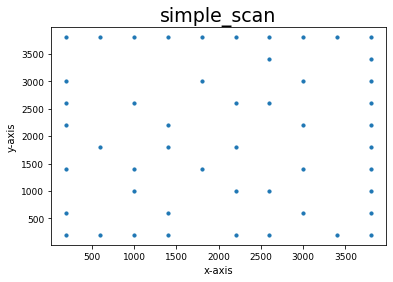

In [45]:
draw_points(xy, "simple_scan")